In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
        
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import mlflow
from mlflow.models import infer_signature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
import shap

In [2]:
df = pd.read_csv("dataframe_final.csv")

In [35]:
# To start the mlflow server in local : mlflow server --host 127.0.0.1 --port 8080

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Projet7_Mean")

<Experiment: artifact_location='mlflow-artifacts:/381266605603233152', creation_time=1707826860654, experiment_id='381266605603233152', last_update_time=1708360234569, lifecycle_stage='active', name='Projet7_Mean', tags={}>

In [4]:
def custom_score_func(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    FN = cf_matrix[1,0]
    FP = cf_matrix[0,1]

    return (10*FN+FP)/y.shape[0]

In [5]:
custom_scorer = make_scorer(custom_score_func, greater_is_better=False)

In [6]:
scoring = {"AUC": "roc_auc", "CustomScorer": custom_scorer}

In [7]:
def calcul_metrics(model, X, y):
    """Fonction de calcul des metriques précision, AUC et score_metier en fonction du modèle en entrée. Retourne un dictionnaire."""
    metrics = {}
    
    accuracy = model.score(X, y)
    print(f'Précision : {accuracy:.2f}')
    metrics['accuracy'] = accuracy
    
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    print(f'AUC : {roc_auc:.2f}')
    metrics['roc_auc'] = roc_auc

    score_metier = custom_score_func(y, model.predict(X))
    print(f'Score métier : {score_metier}')
    metrics['score_metier'] = score_metier

    return metrics
    

In [8]:
def logToMLflow(model, X, eval_data, metrics, name="", params="", training_tag=""):
    # Start an MLflow run
    with mlflow.start_run(run_name=name):
        # Log the hyperparameters
        if params:
            mlflow.log_params(params)

        # Log the loss metric
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])
        mlflow.log_metric("score_metier", metrics['score_metier'])
    
        # Set a tag that we can use to remind ourselves what this run was for
        if training_tag:
            mlflow.set_tag("Training Info", training_tag)
    
        # Infer the model signature
        signature = infer_signature(X, model.predict(X))
    
        # Log the model
        model_info = mlflow.sklearn.log_model(model, 'model', signature=signature)

        result = mlflow.evaluate(
            model_info.model_uri,
            eval_data,
            targets="TARGET",
            model_type="classifier",
            evaluators=["default"],
        )

In [9]:
def displayConfMatrix(model, valid_x, valid_y):
    plt.figure(figsize=(12,6))
    cf_matrix = confusion_matrix(valid_y, model.predict(valid_x))
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

In [10]:
#Fonction d'affichage des résultats d'un GridSearch.

def resultizeGrid(grid):
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values('rank_test_CustomScorer')
    
    return res

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [11]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [30]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]

train_x, valid_x, train_y, valid_y = train_test_split(train_df[feats], train_df['TARGET'], test_size=0.15, random_state=0)

In [31]:
col = train_x.columns

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

train_x = pd.DataFrame(train_x, columns=col)
valid_x = pd.DataFrame(valid_x, columns=col)

val_data = pd.concat([valid_x.reset_index(drop=True), valid_y.reset_index(drop=True)], axis=1)

In [32]:
train_x_100k = train_x[:100000]
train_y_100k = train_y[:100000]

train_x_30k = train_x[:30000]
train_y_30k = train_y[:30000]

train_x_10k = train_x[:10000]
train_y_10k = train_y[:10000]

In [68]:
test_feats = [f for f in test_df.columns if f not in ['TARGET']]

test_x = test_df[test_feats]
col = test_x.columns

test_x.replace([np.inf, -np.inf], np.nan, inplace=True)
test_x = imp.fit_transform(test_x)
test_x = pd.DataFrame(test_x, columns=col)

test_x.to_csv("dataframe_final_test.csv", index=False)

# LOGISTIC REGRESSION

## Without SMOTE

Gestion des valeurs manquantes.

Précision : 0.92
AUC : 0.51
Score métier : 0.7945671732391008


2024/02/19 14:57:54 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 14:57:54 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 14:57:55 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 14:57:55 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 14:57:58 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Linear is used.
2024/02/19 14:57:58 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'LogisticRegression' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


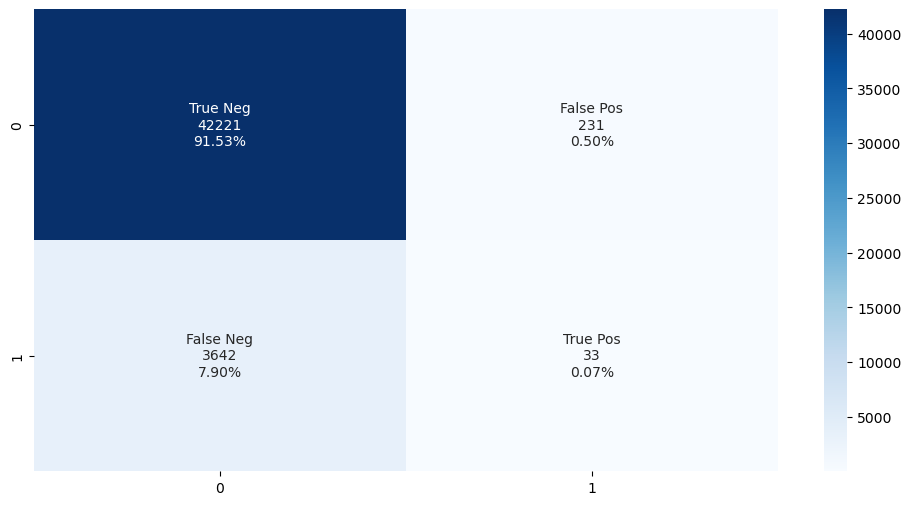

CPU times: total: 22.9 s
Wall time: 27.8 s


In [35]:
%%time

lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

metrics = calcul_metrics(lr, valid_x, valid_y)

logToMLflow(lr, train_x, val_data, metrics, name="LogReg_noSmote_noParam", training_tag="Basic LR model no SMOTE no param")

displayConfMatrix(lr, valid_x, valid_y)

## With SMOTE

### No Param

Précision : 0.21
AUC : 0.53
Score métier : 0.8751273657510785


2024/02/19 14:59:26 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 14:59:26 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 14:59:27 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 14:59:27 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 14:59:30 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 14:59:30 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

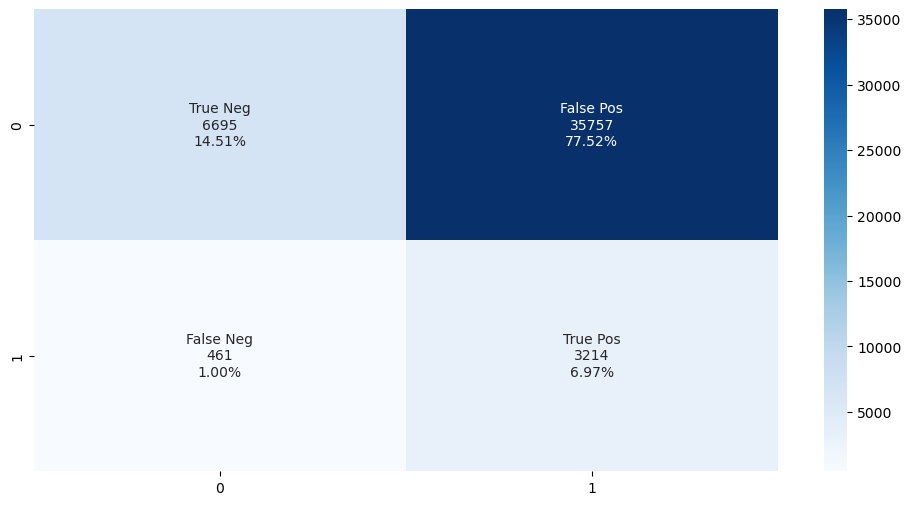

CPU times: total: 52.3 s
Wall time: 1min 1s


In [36]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)


metrics = calcul_metrics(pipeline, valid_x, valid_y)

logToMLflow(pipeline, train_x, val_data, metrics, name="LogReg_Smote_noParam", training_tag="Basic LR model with SMOTE no param")

displayConfMatrix(pipeline, valid_x, valid_y)

# RandomForest

## Baseline, paramètres par défaut

### Sans SMOTE

In [ ]:
%%time

RFC_base = RandomForestClassifier(random_state=0)
RFC_base.fit(train_x, train_y)

metrics = calcul_metrics(RFC_base, valid_x, valid_y)

logToMLflow(RFC_base, train_x, val_data, metrics, name="RndForest_noSmote_noParam", training_tag="RandomForest model no SMOTE no param")
displayConfMatrix(RFC_base, valid_x, valid_y)

Précision : 0.92
AUC : 0.71
Score métier : 0.7954126650334945


2024/02/19 15:28:56 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 15:28:57 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 15:29:00 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 15:29:04 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 15:29:08 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.


### Avec SMOTE

In [16]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

#logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
#displayConfMatrix(pipeline, valid_x, valid_y)

Précision : 0.92
AUC : 0.66
Score métier : 0.7627203156502699
CPU times: total: 9min 57s
Wall time: 11min 15s


2024/02/19 15:44:52 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 15:44:52 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 15:44:56 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 15:44:59 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 15:45:03 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 15:45:03 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

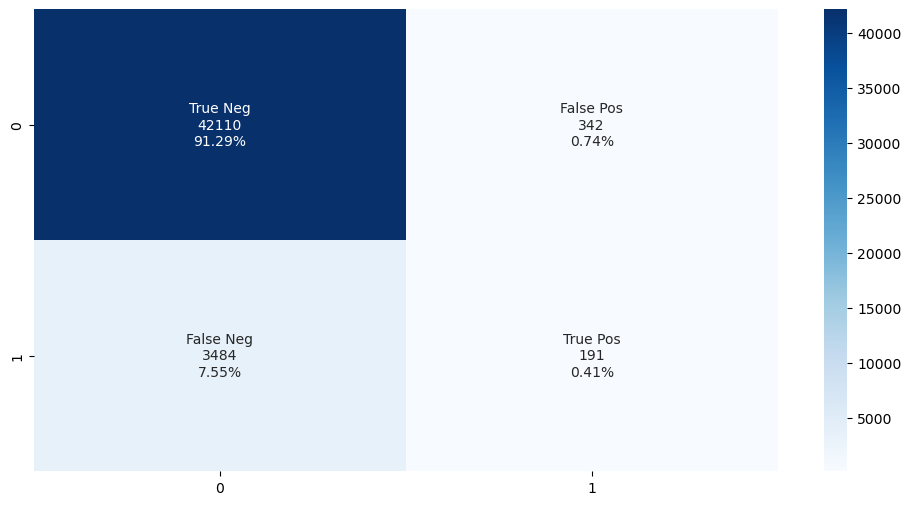

In [17]:
logToMLflow(pipeline, train_x, val_data, metrics, name="RndForest_WithSmote_noParam", training_tag="RandomForest model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

## Recherche des meilleurs hyperparamètres

In [54]:
rftest = RandomForestClassifier()
print('Liste des paramètres de RandomForestClassifier :\n')
print(rftest.get_params())

Liste des paramètres de RandomForestClassifier :

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Utilisation de RandomizedSearchCV sur un nombre important de paramètres pour avoir une idée globale.

In [63]:
%%time

params = {
    'model__bootstrap': [True, False],
    'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10],
    'model__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

rf_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0)
# Fit the random search model
rf_random.fit(train_x_10k, train_y_10k)

print("Best parameters :",rf_random.best_params_)
print("Score :",rf_random.best_score_)
resultizeGrid(rf_random)

tuned hyperparameters :(best parameters)  {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': True}
accuracy : -0.8165992064113429
CPU times: total: 1min 2s
Wall time: 1h 1min 53s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
49,95.684098,1.277924,0.706464,0.033683,600,2,sqrt,10,True,"{'model__n_estimators': 600, 'model__min_sampl...",0.711850,0.021174,17,-0.816599,0.009541,1
16,285.733666,1.999877,2.024920,0.399457,1200,1,sqrt,30,True,"{'model__n_estimators': 1200, 'model__min_samp...",0.710564,0.022846,27,-0.820100,0.002850,2
64,370.663151,3.110898,2.462478,0.019478,1600,1,sqrt,None,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
27,373.160966,1.392382,2.473115,0.164365,1600,1,sqrt,80,True,"{'model__n_estimators': 1600, 'model__min_samp...",0.710262,0.021824,29,-0.820100,0.002850,2
39,58.306726,1.330677,0.343327,0.059657,200,4,sqrt,80,False,"{'model__n_estimators': 200, 'model__min_sampl...",0.704633,0.022198,49,-0.820100,0.002850,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.373358,0.026176,0.000000,0.000000,2000,2,auto,40,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
36,0.396557,0.028497,0.000000,0.000000,1000,1,auto,10,False,"{'model__n_estimators': 1000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
69,0.430621,0.037382,0.000000,0.000000,2000,1,auto,30,False,"{'model__n_estimators': 2000, 'model__min_samp...",NaN,NaN,53,NaN,NaN,53
56,0.369793,0.018900,0.000000,0.000000,800,4,auto,10,False,"{'model__n_estimators': 800, 'model__min_sampl...",NaN,NaN,53,NaN,NaN,53


Réduction des paramètres en fonction du résultat précédent. GridSearchCV pour trouver les paramètres finaux optimaux.

In [18]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [10, 20, 30, None],
    'model__max_features': ['sqrt']
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_RF.fit(train_x_30k, train_y_30k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt'}
Score : -0.7766333333333334
CPU times: total: 10min 22s
Wall time: 13min 3s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,25.215234,0.274749,0.145925,0.002050,True,10,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.693956,0.010536,4,-0.776633,0.013820,1
1,38.673245,0.329367,0.214399,0.001480,True,20,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.702435,0.005844,1,-0.804400,0.003065,2
3,43.300079,0.375735,0.230703,0.006291,True,None,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.701374,0.004961,3,-0.806667,0.001571,3
2,42.393760,0.491442,0.230204,0.004387,True,30,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.701377,0.003075,2,-0.806800,0.002042,4


Application des meilleurs paramètres :

Best params : {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt'}
Précision : 0.87
AUC : 0.66
Score métier : 0.6973139376070414


2024/02/19 16:03:54 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:03:54 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:03:56 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:03:57 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:04:00 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 16:04:00 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

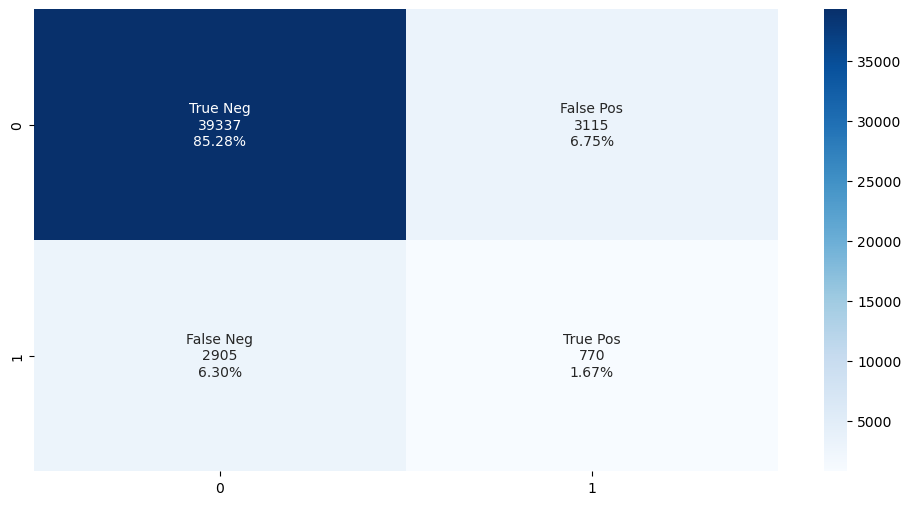

In [19]:
print(f'Best params : {GS_RF.best_params_}')

metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

In [20]:
%%time

params = {
    'model__bootstrap': [True],
    'model__max_depth': [3, 5],
    'model__max_features': ['sqrt']
}

steps = [('over', SMOTE(random_state=0)), ('model', RandomForestClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_RF = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_RF.fit(train_x_30k, train_y_30k)

print("Best parameters :",GS_RF.best_params_)
print("Score :",GS_RF.best_score_)
resultizeGrid(GS_RF)

Best parameters : {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 'sqrt'}
Score : -0.6940333333333333
CPU times: total: 1min 42s
Wall time: 2min 5s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
0,8.778446,0.074433,0.091387,0.003789,True,3,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.662454,0.010540,2,-0.694033,0.013565,1
1,13.858106,0.310252,0.100170,0.002063,True,5,sqrt,"{'model__bootstrap': True, 'model__max_depth':...",0.676469,0.009528,1,-0.718167,0.015943,2


Best params : {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': 'sqrt'}
Précision : 0.74
AUC : 0.64
Score métier : 0.6707785028291456


2024/02/19 16:07:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:07:18 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:07:19 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:07:20 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:07:23 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 16:07:23 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

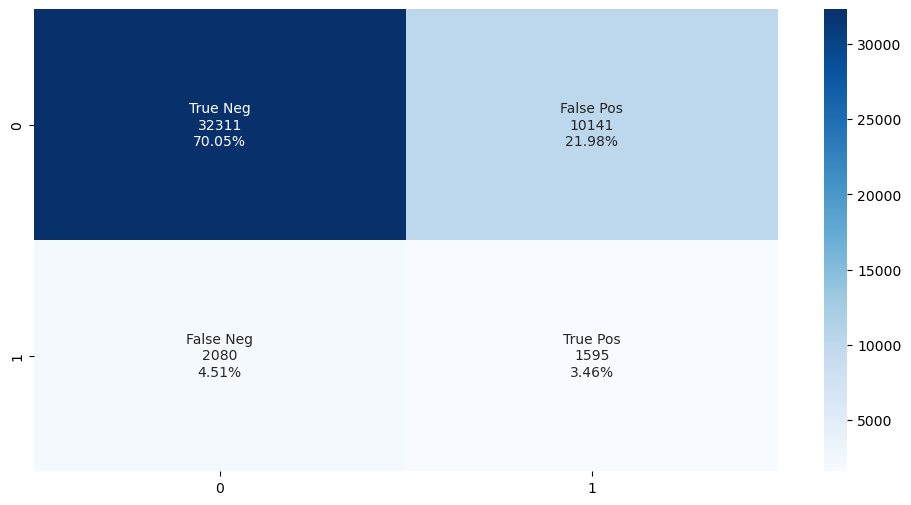

In [21]:
print(f'Best params : {GS_RF.best_params_}')

metrics = calcul_metrics(GS_RF.best_estimator_, valid_x, valid_y)

logToMLflow(GS_RF.best_estimator_, train_x, val_data, metrics, name="RndForest_Smote_GridSearch", params=GS_RF.best_params_, training_tag="RandomForest model with SMOTE")
displayConfMatrix(GS_RF.best_estimator_, valid_x, valid_y)

100%|===================| 91914/92254 [02:12<00:00]        

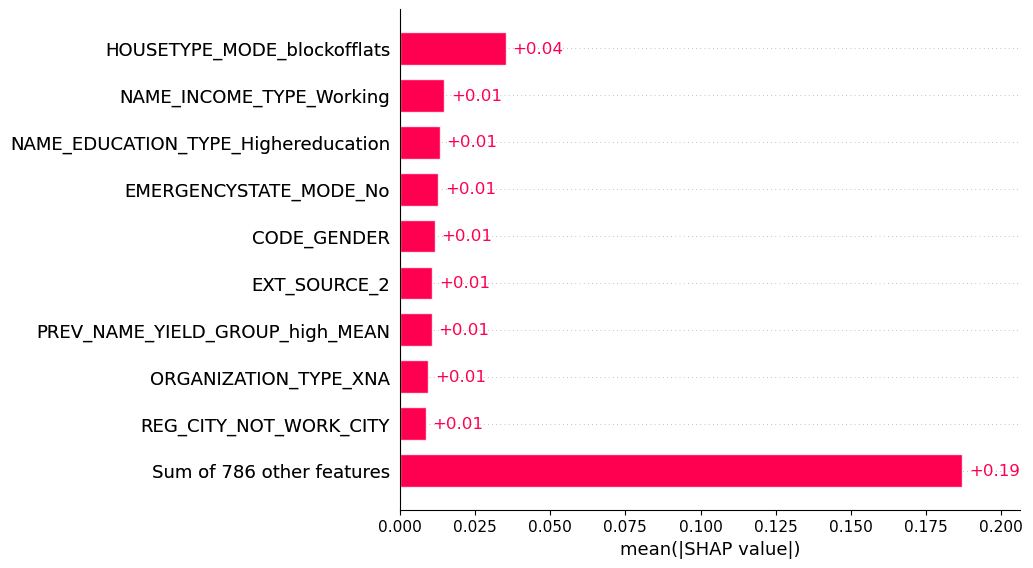

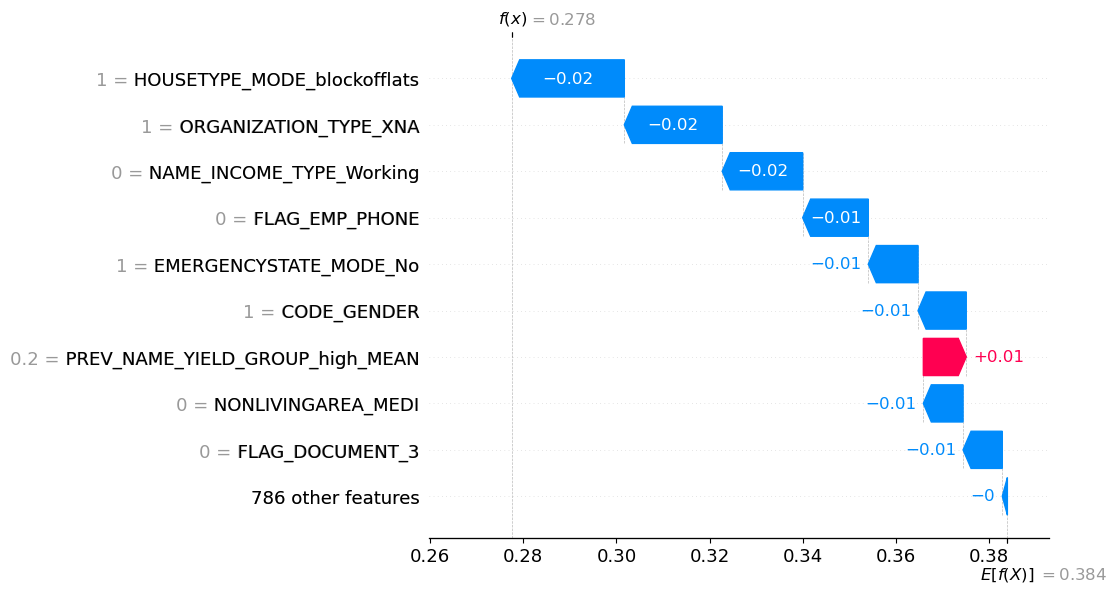

In [22]:
tree_explainer = shap.TreeExplainer(GS_RF.best_estimator_[1], train_x_30k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values[:,:,1])
shap.plots.waterfall(shap_values[:,:,1][50])

# LIGHTGBM

## Pramètres par défaut

### Sans SMOTE

[LightGBM] [Info] Number of positive: 21150, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98844
[LightGBM] [Info] Number of data points in the train set: 261380, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080917 -> initscore=-2.429957
[LightGBM] [Info] Start training from score -2.429957
Précision : 0.92
AUC : 0.78
Score métier : 0.7827086088408091


2024/02/19 16:10:18 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:10:18 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:10:19 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:10:20 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:10:23 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
2024/02/19 16:10:30 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: AttributeError("'TreeEnsemble' object has no attribute 'save'"). Set logging level to DEBUG to see the full traceback.


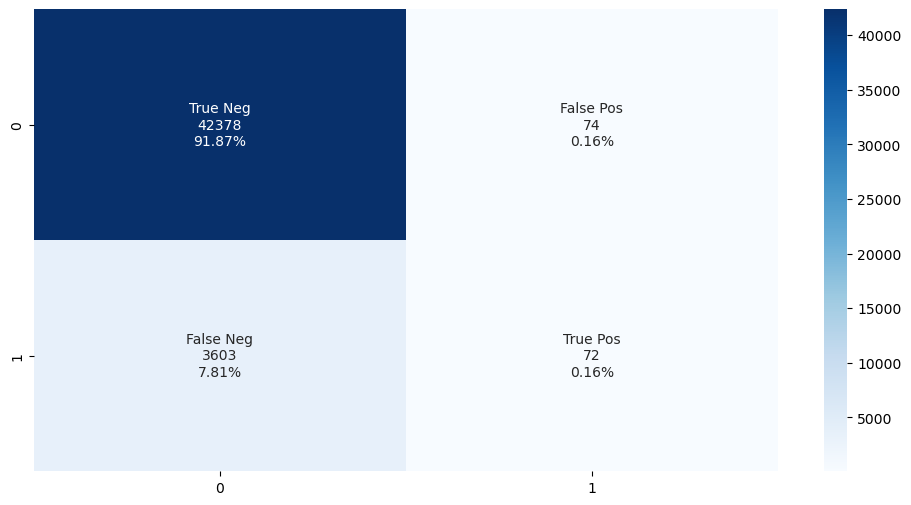

CPU times: total: 43.8 s
Wall time: 34.9 s


In [23]:
%%time

LGBM_base = LGBMClassifier(random_state=0)
LGBM_base.fit(train_x, train_y)

metrics = calcul_metrics(LGBM_base, valid_x, valid_y)

logToMLflow(LGBM_base, train_x, val_data, metrics, name="LGBM_noSmote_noParam", training_tag="LGBM model no SMOTE no param")
displayConfMatrix(LGBM_base, valid_x, valid_y)

### Avec SMOTE

[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.068944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172957
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 749
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Précision : 0.92
AUC : 0.77
Score métier : 0.7769852797710668


2024/02/19 16:11:46 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 16:11:46 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 16:11:47 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 16:11:48 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 16:11:51 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 16:11:51 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1207!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

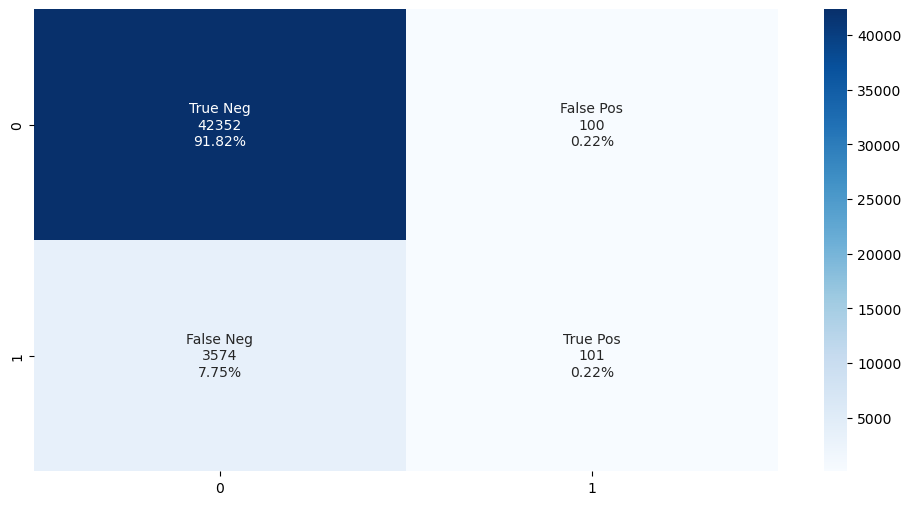

CPU times: total: 2min 3s
Wall time: 1min 3s


In [24]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_WithSmote_noParam", training_tag="LGBM model with SMOTE no param")
displayConfMatrix(pipeline, valid_x, valid_y)

100%|===================| 46089/46127 [03:04<00:00]        

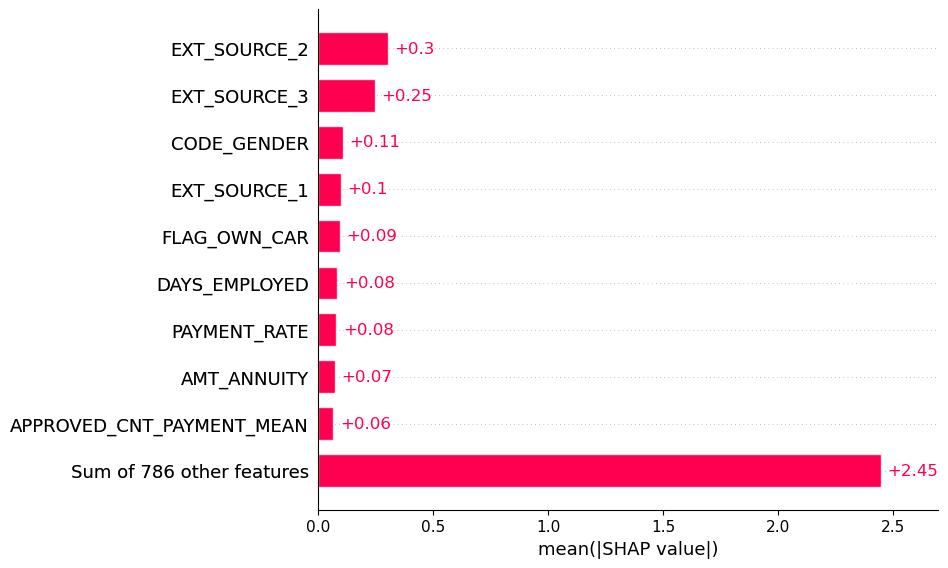

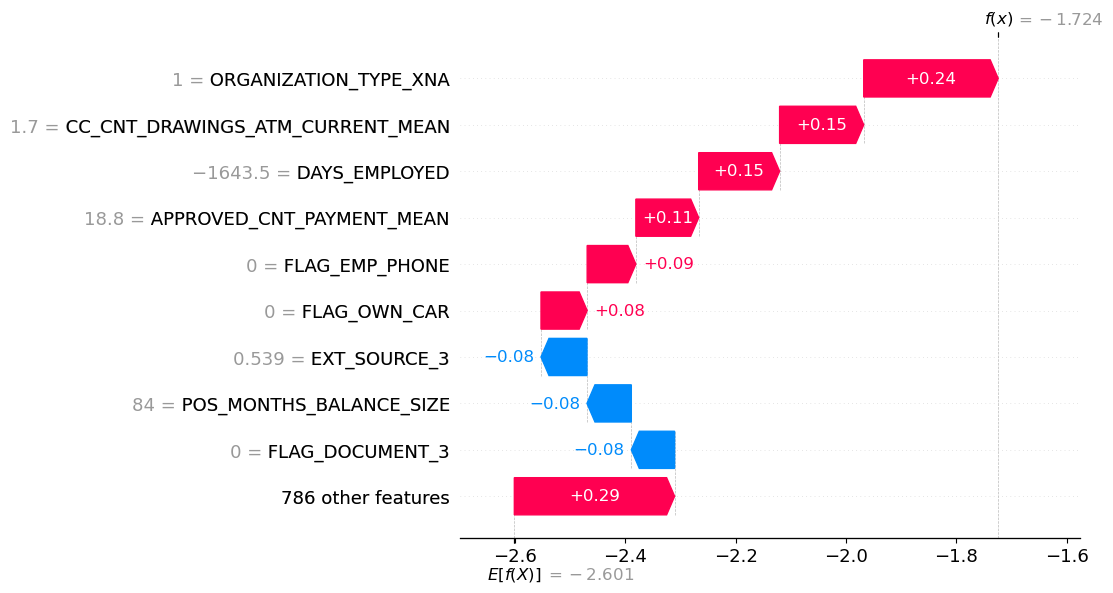

In [25]:
tree_explainer = shap.TreeExplainer(pipeline[1], train_x_30k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

## Recherche des meilleurs hyperparamètres

In [30]:
lgbmtest = LGBMClassifier()
print('Liste des paramètres de LGBMClassifier :\n')
print(lgbmtest.get_params())

Liste des paramètres de LGBMClassifier :

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [26]:
%%time

params = {
    'model__num_leaves': [30, 40, 50, 60],
    'model__max_depth': [5, 7, 10, 15, -1]
}
    
steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)

lgbm_random = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring=scoring, refit="CustomScorer", cv = 3, random_state=0)
# Fit the random search model
lgbm_random.fit(train_x_30k, train_y_30k)

print("Best parameters :",lgbm_random.best_params_)
print("Score :",lgbm_random.best_score_)
resultizeGrid(lgbm_random)

[LightGBM] [Info] Number of positive: 18382, number of negative: 18382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154325
[LightGBM] [Info] Number of data points in the train set: 36764, number of used features: 720
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__num_leaves,param_model__n_estimators,param_model__max_depth,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
8,11.955605,0.249320,0.203172,0.005702,30,700,5,"{'model__num_leaves': 30, 'model__n_estimators...",0.736546,0.006769,39,-0.778167,0.003704,1
4,7.722489,0.087522,0.130685,0.007157,30,400,5,"{'model__num_leaves': 30, 'model__n_estimators...",0.746152,0.005201,24,-0.779500,0.002531,2
9,12.225177,0.105152,0.207154,0.002067,40,700,5,"{'model__num_leaves': 40, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
10,12.451715,0.262855,0.193720,0.002717,50,700,5,"{'model__num_leaves': 50, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
11,12.472314,0.134022,0.194328,0.002153,60,700,5,"{'model__num_leaves': 60, 'model__n_estimators...",0.737360,0.004368,33,-0.780600,0.003102,3
5,7.961336,0.278781,0.129665,0.003823,40,400,5,"{'model__num_leaves': 40, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
6,7.938553,0.088950,0.137785,0.015192,50,400,5,"{'model__num_leaves': 50, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
7,7.972032,0.166792,0.136459,0.005372,60,400,5,"{'model__num_leaves': 60, 'model__n_estimators...",0.747959,0.004592,21,-0.780800,0.001608,6
39,6.348656,0.091469,0.090449,0.013256,60,100,15,"{'model__num_leaves': 60, 'model__n_estimators...",0.753214,0.004166,14,-0.781067,0.002796,9
51,6.167607,0.025830,0.081741,0.003685,60,100,-1,"{'model__num_leaves': 60, 'model__n_estimators...",0.750323,0.003277,18,-0.781267,0.002504,10


In [28]:
%%time

params = {
    'model__num_leaves': [40, 50, 60],
    'model__max_depth': [10, 20, -1]
}

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_LGBM = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_LGBM.fit(train_x_100k, train_y_100k)

print("Best parameters :",GS_LGBM.best_params_)
print("Score :",GS_LGBM.best_score_)
resultizeGrid(GS_LGBM)

[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.460381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172544
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.464743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170514
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 736
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73530, number of negative: 73530
[LightGBM] [Info] Auto-choosing col-wise mu

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
8,17.161208,0.846264,0.174761,0.014938,-1,60,"{'model__max_depth': -1, 'model__num_leaves': 60}",0.764971,0.007077,5,-0.78366,0.001716,1
2,15.482274,0.078420,0.168353,0.006830,10,60,"{'model__max_depth': 10, 'model__num_leaves': 60}",0.764389,0.005695,9,-0.78383,0.002080,2
5,16.458284,0.057079,0.163749,0.005683,20,60,"{'model__max_depth': 20, 'model__num_leaves': 60}",0.764808,0.007144,8,-0.78403,0.000676,3
4,15.566785,0.096846,0.166551,0.008097,20,50,"{'model__max_depth': 20, 'model__num_leaves': 50}",0.765040,0.008392,4,-0.78479,0.002320,4
7,16.234557,0.707893,0.156943,0.009815,-1,50,"{'model__max_depth': -1, 'model__num_leaves': 50}",0.764859,0.008138,7,-0.78504,0.001473,5
1,14.789043,0.146941,0.159546,0.006285,10,50,"{'model__max_depth': 10, 'model__num_leaves': 50}",0.764884,0.004736,6,-0.78568,0.003171,6
3,14.858506,0.702766,0.165551,0.012796,20,40,"{'model__max_depth': 20, 'model__num_leaves': 40}",0.766861,0.005279,1,-0.78643,0.002859,7
6,14.944985,0.521158,0.157743,0.004677,-1,40,"{'model__max_depth': -1, 'model__num_leaves': 40}",0.766680,0.005456,2,-0.78679,0.002716,8
0,14.151736,0.066791,0.162348,0.006280,10,40,"{'model__max_depth': 10, 'model__num_leaves': 40}",0.765660,0.006387,3,-0.78723,0.002228,9


In [33]:
%%time

params = {
    'model__num_leaves': [50, 60],
    'model__max_depth': [10, -1]
}

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
GS_LGBM = GridSearchCV(pipeline, params, scoring=scoring, refit="CustomScorer")

GS_LGBM.fit(train_x_100k, train_y_100k)

print("Best parameters :",GS_LGBM.best_params_)
print("Score :",GS_LGBM.best_score_)
resultizeGrid(GS_LGBM)

[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180103
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 759
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73529, number of negative: 73529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179905
[LightGBM] [Info] Number of data points in the train set: 147058, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 73530, number of negative: 73530
[LightGBM] [Info] Auto-choosing col-wise mu

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_CustomScorer,std_test_CustomScorer,rank_test_CustomScorer
3,19.152135,0.079104,0.160244,0.002379,-1,60,"{'model__max_depth': -1, 'model__num_leaves': 60}",0.763409,0.005213,4,-0.77965,0.003122,1
1,18.011865,0.148535,0.169083,0.012031,10,60,"{'model__max_depth': 10, 'model__num_leaves': 60}",0.764685,0.005196,3,-0.78174,0.003028,2
0,17.481851,0.333214,0.174041,0.009447,10,50,"{'model__max_depth': 10, 'model__num_leaves': 50}",0.765206,0.006703,2,-0.78267,0.003305,3
2,18.084096,0.075915,0.171687,0.008056,-1,50,"{'model__max_depth': -1, 'model__num_leaves': 50}",0.765386,0.006070,1,-0.78280,0.002066,4


Best params : {'model__max_depth': -1, 'model__num_leaves': 60}
Précision : 0.87
AUC : 0.74
Score métier : 0.6614780930908145


2024/02/19 17:29:46 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 17:29:46 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/19 17:29:46 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/19 17:29:47 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 17:29:50 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 17:29:50 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

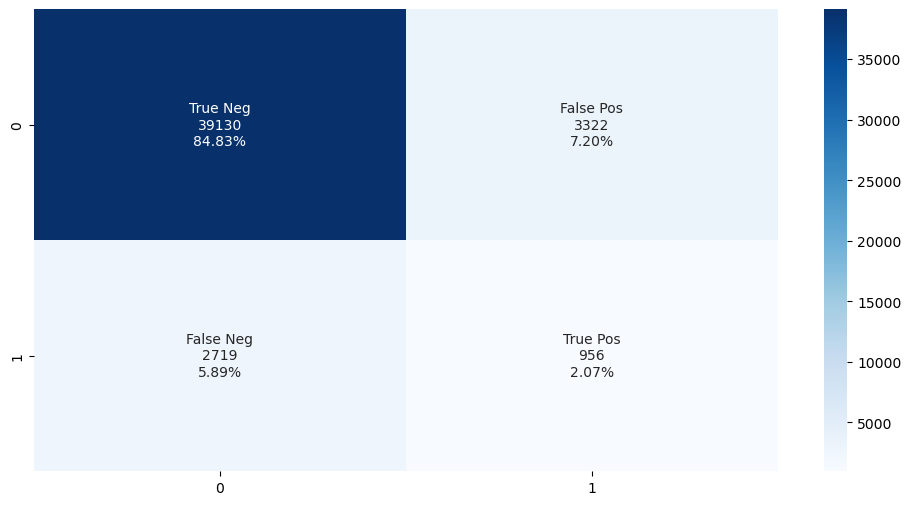

In [34]:
print(f'Best params : {GS_LGBM.best_params_}')

metrics = calcul_metrics(GS_LGBM.best_estimator_, valid_x, valid_y)

logToMLflow(GS_LGBM.best_estimator_, train_x, val_data, metrics, name="LGBM_Smote_GridSearch", params=GS_LGBM.best_params_, training_tag="LightGBM model with SMOTE")
displayConfMatrix(GS_LGBM.best_estimator_, valid_x, valid_y)

Précision : 0.86
AUC : 0.73
Score métier : 0.6513321915580896


2024/02/17 14:06:12 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/17 14:06:12 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/17 14:06:13 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/17 14:06:13 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/17 14:06:17 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/17 14:06:17 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


<Figure size 1050x700 with 0 Axes>

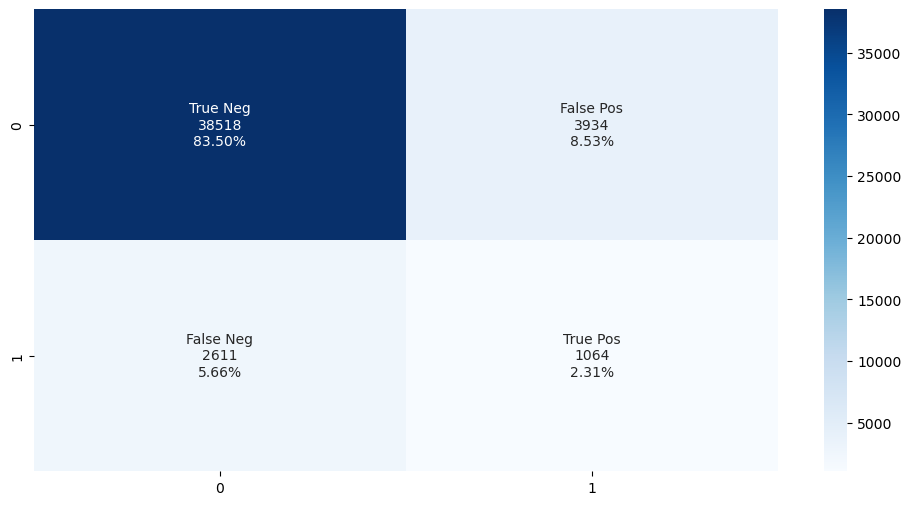

In [33]:
metrics = calcul_metrics(GS_LGBM.best_estimator_, valid_x, valid_y)

logToMLflow(GS_LGBM.best_estimator_, train_x, val_data, metrics, name="LGBM_Smote_GridSearch", params=GS_LGBM.best_params_, training_tag="LightGBM model with SMOTE")
displayConfMatrix(GS_LGBM.best_estimator_, valid_x, valid_y)

100%|===================| 46125/46127 [03:42<00:00]        

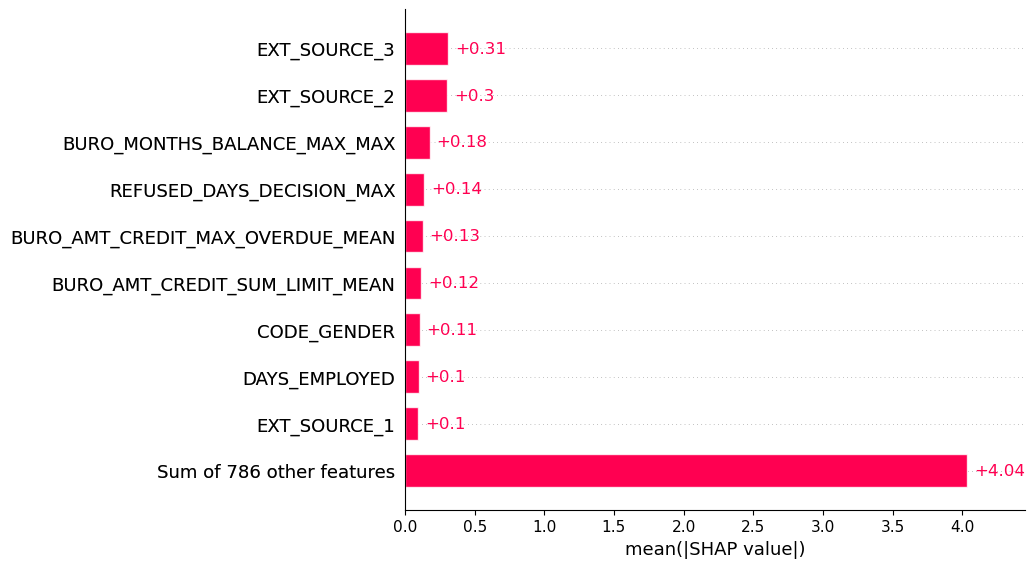

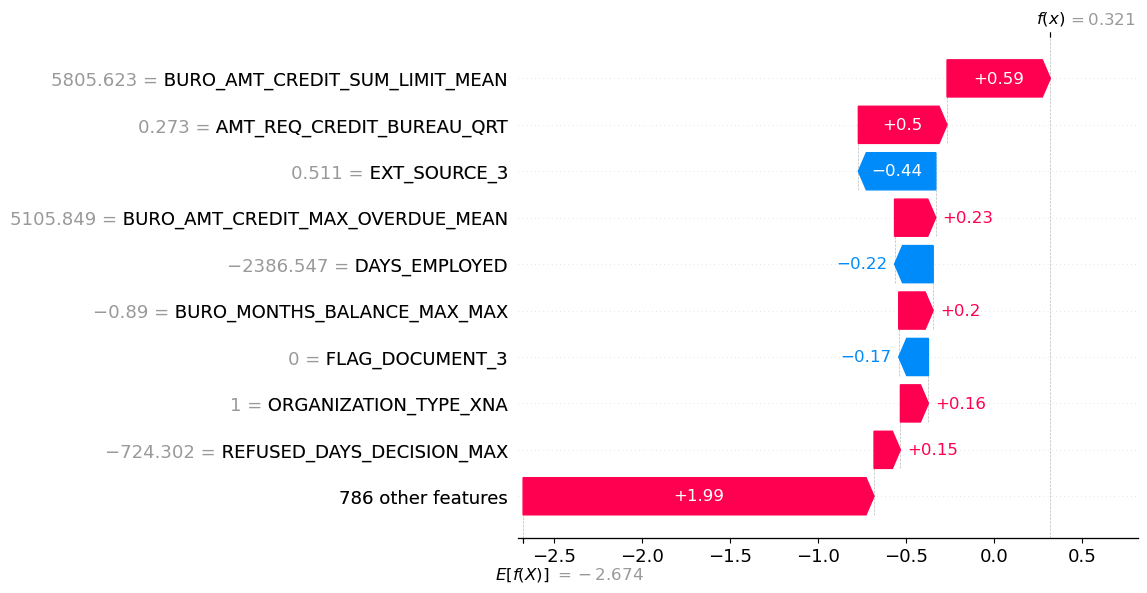

In [34]:
tree_explainer = shap.TreeExplainer(GS_LGBM.best_estimator_[1], train_x_100k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

# Test avec LGBM paramètres de Kaggle

In [46]:
%%time


clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(train_x, train_y)

CPU times: total: 29min 5s
Wall time: 10min 55s


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

Précision : 0.92
AUC : 0.78
Score métier : 0.7525960933943243


2024/02/13 17:01:51 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/13 17:01:51 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/13 17:02:05 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/02/13 17:02:18 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/13 17:02:36 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Tree is used.
100%|===================| 1998/2000 [09:32<00:00]        2024/02/13 17:12:09 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ExplainerError('Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of t

<Figure size 1050x700 with 0 Axes>

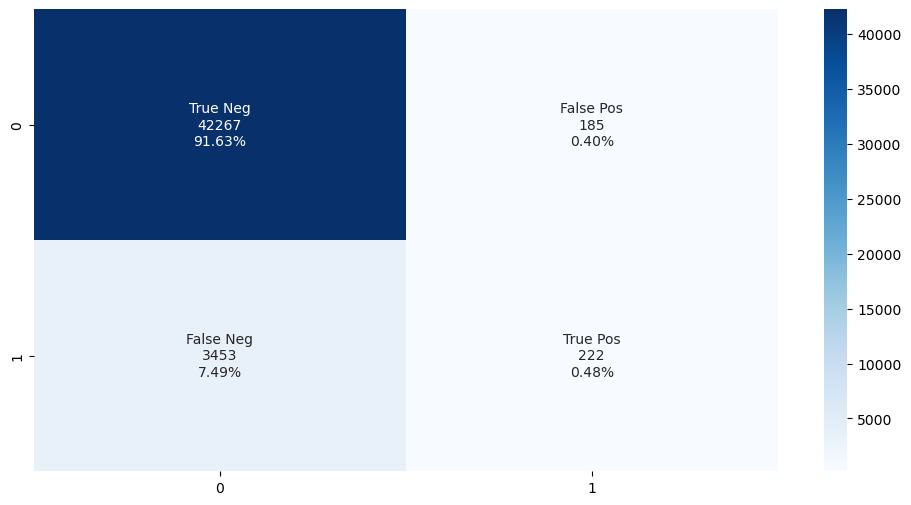

In [47]:
metrics = calcul_metrics(clf, valid_x, valid_y)

logToMLflow(clf, train_x, val_data, metrics, name="LGBM_BestFromKaggle", params=clf.get_params(), training_tag="LightGBM model from Kaggle")
displayConfMatrix(clf, valid_x, valid_y)

# Meilleur modèle : Optimisation du threshold

In [22]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

probs = pipeline.predict_proba(valid_x)

for threshold in np.arange(0, 1, 0.05):
    preds = (probs[:,1] >= threshold).astype(int)
    score_metier = custom_score_func(valid_y, preds)
    print(f'Threshold : {threshold}, Score métier : {score_metier}')

[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.735619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181351
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Threshold : 0.0, Score métier : 0.9203286578359746
Threshold : 0.05, Score métier : 0.7823617404123399
Threshold : 0.1, Score métier : 0.6353762438485052
Threshold : 0.15000000000000002, Score métier : 0.5736770221345416
Threshold : 0.2, Score métier : 0.5558132980683764
Threshold : 0.25, Score métier : 0.5576777158713986
Threshold : 0.30000000000000004, Score métier : 0.5675201075292128
Threshold : 0.35000000000000003, Score métier : 0.5919960110130726
Threshold : 0.4, Score métier : 0.611333925900232
Threshold : 0.45, Score métier : 0.634682506991

In [ ]:
tree_explainer = shap.TreeExplainer(pipeline[1], train_x)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 165386, number of negative: 165386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.184537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181587
[LightGBM] [Info] Number of data points in the train set: 330772, number of used features: 764
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Précision : 0.86
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
AUC : 0.74
[LightGBM] [Warning] min_data_in_leaf is set=8,

2024/02/19 19:17:15 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 19:17:15 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 19:17:16 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 19:17:17 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 19:17:20 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 19:17:20 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


<Figure size 1050x700 with 0 Axes>

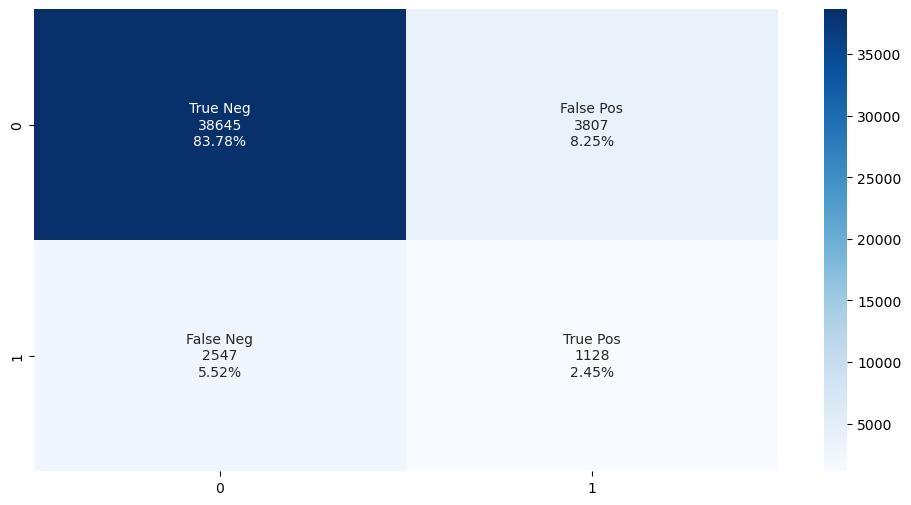

CPU times: total: 4min 33s
Wall time: 1min 43s


In [75]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x_180k, train_y_180k)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

parameters = {'n_estimators': 500, 'num_leaves': 65, 'min_data_in_leaf': 8}

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_Best", params=parameters, training_tag="LGBM Best")
displayConfMatrix(pipeline, valid_x, valid_y)

In [74]:
train_x_180k = train_x[:180000]
train_y_180k = train_y[:180000]

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 240230, number of negative: 240230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.713848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 181355
[LightGBM] [Info] Number of data points in the train set: 480460, number of used features: 766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
Précision : 0.85
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
AUC : 0.75
[LightGBM] [Warning] min_data_in_leaf is set=8,

2024/02/19 18:59:03 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/19 18:59:03 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 18:59:05 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


2024/02/19 18:59:06 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/19 18:59:09 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
2024/02/19 18:59:09 WARNING mlflow.models.evaluation.default_evaluator: Shap evaluation failed. Reason: ValueError('max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1387!'). Set logging level to DEBUG to see the full traceback.


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


<Figure size 1050x700 with 0 Axes>

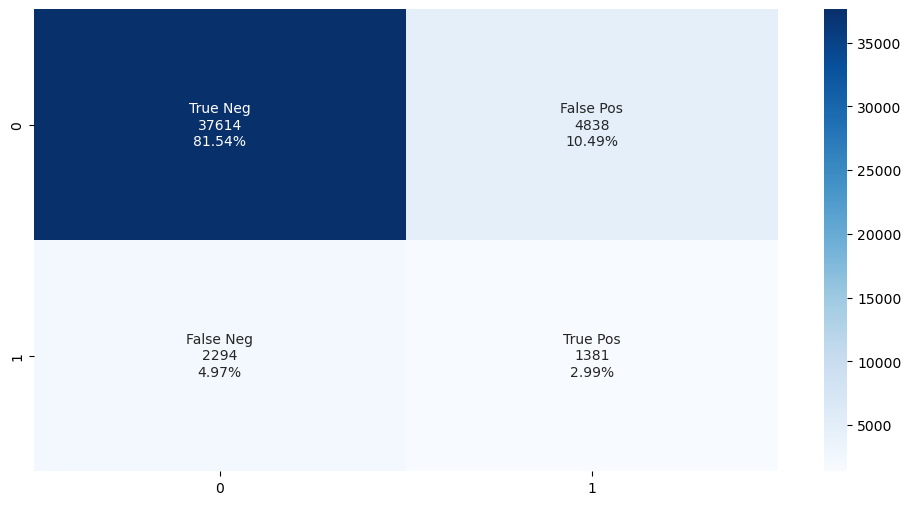

CPU times: total: 5min 36s
Wall time: 2min 16s


In [71]:
%%time

steps = [('over', SMOTE(random_state=0)), ('model', LGBMClassifier(num_leaves=65, n_estimators=500, min_data_in_leaf=8, random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

metrics = calcul_metrics(pipeline, valid_x, valid_y)

parameters = {'n_estimators': 500, 'num_leaves': 65, 'min_data_in_leaf': 8}

logToMLflow(pipeline, train_x, val_data, metrics, name="LGBM_Best", params=parameters, training_tag="LGBM Best")
displayConfMatrix(pipeline, valid_x, valid_y)

100%|===================| 46091/46127 [10:36<00:00]        

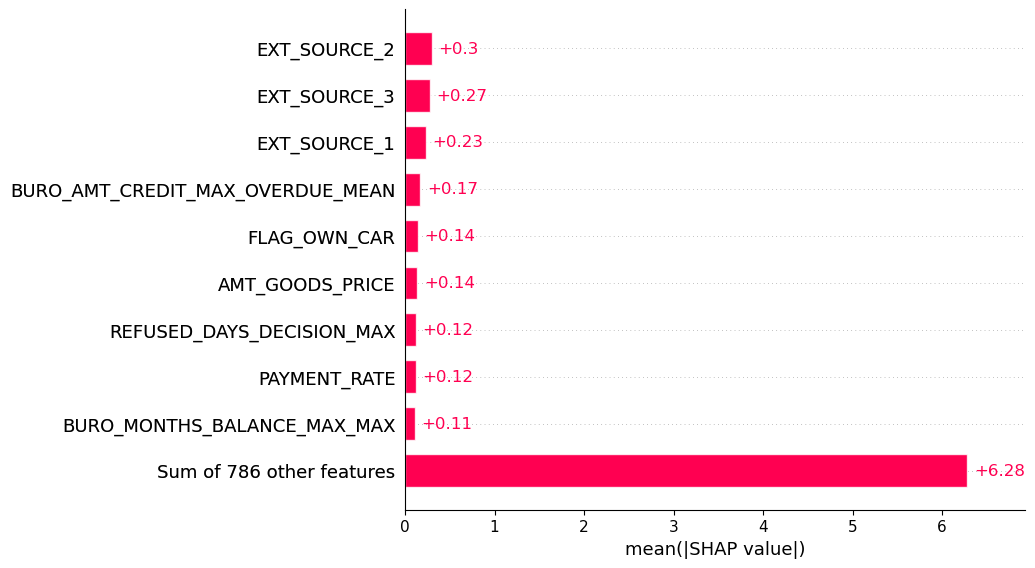

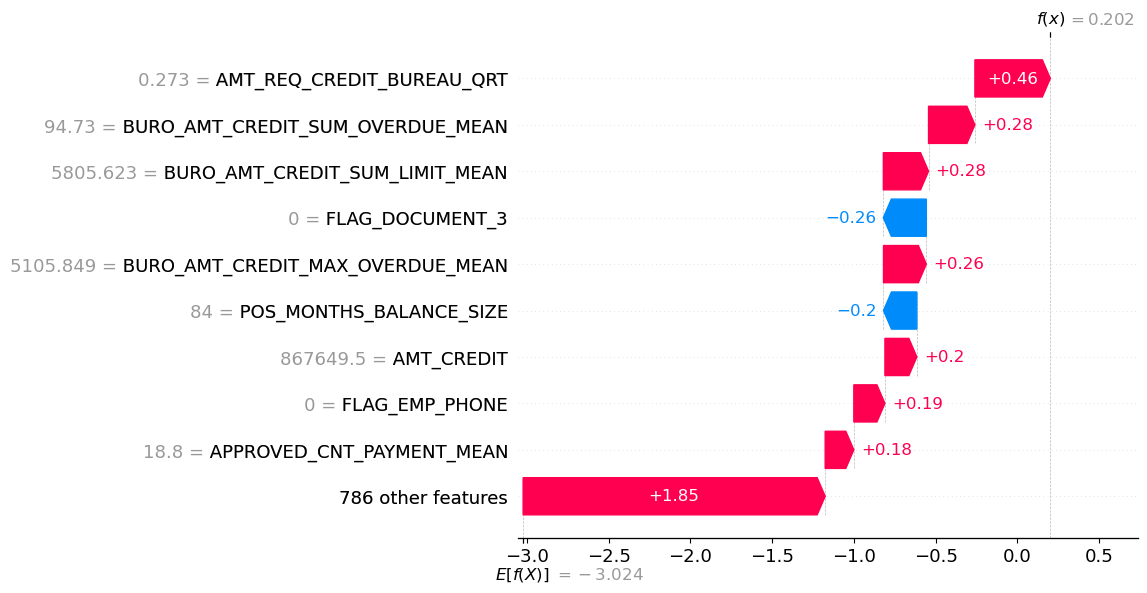

In [67]:
tree_explainer = shap.TreeExplainer(pipeline[1], train_x)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])

100%|===================| 46092/46127 [10:26<00:00]        

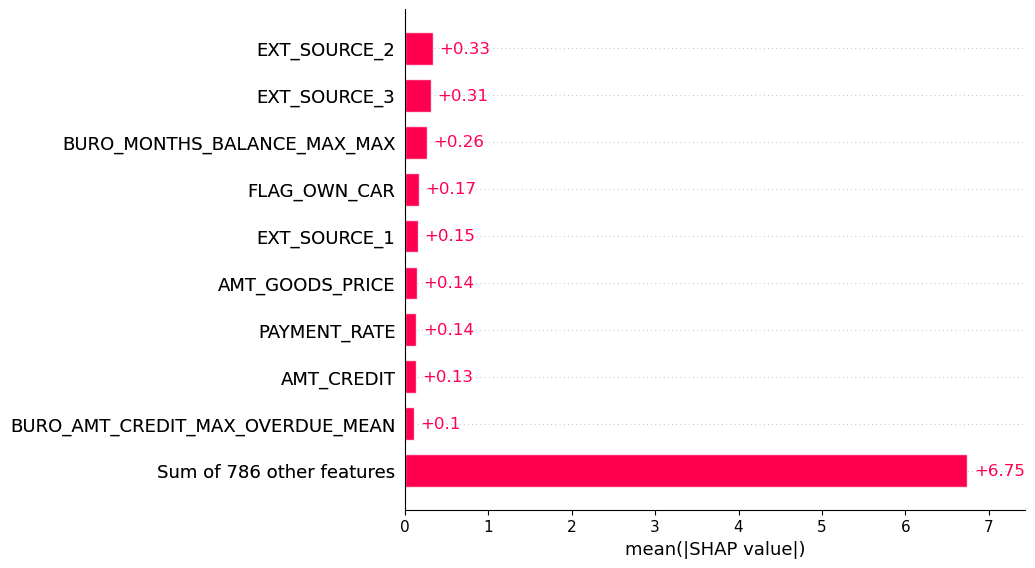

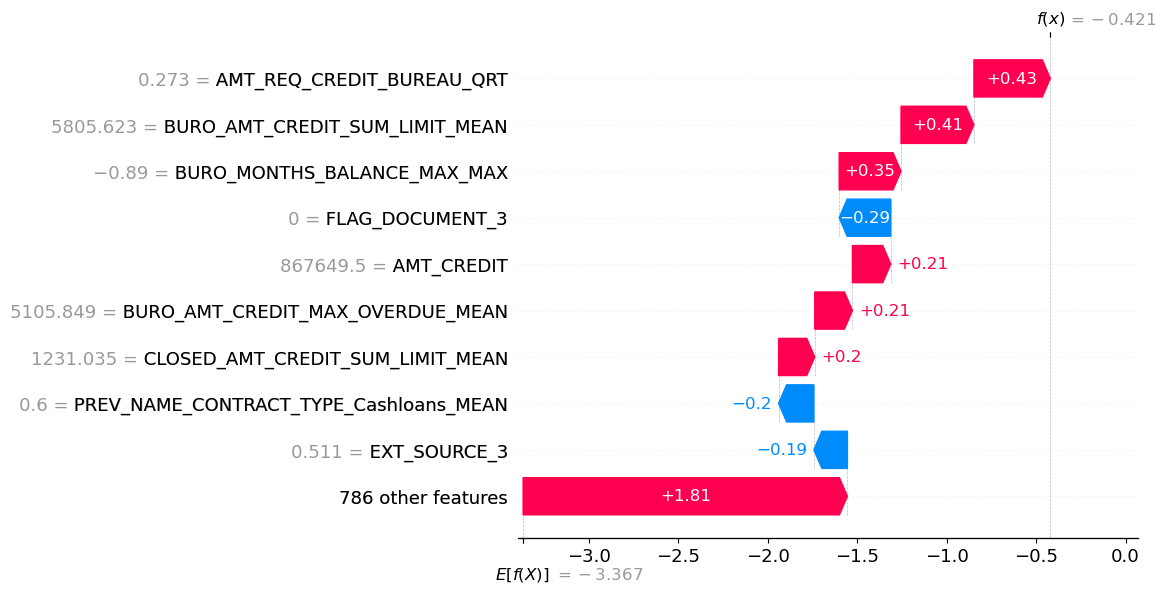

In [76]:
tree_explainer = shap.TreeExplainer(pipeline[1], train_x_180k)

shap_values = tree_explainer(valid_x, check_additivity=False)

shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[50])